In [1]:
import torch
import matplotlib.pyplot as plt

# For inline plotting in Jupyter notebooks (uncomment if needed):
# %matplotlib inline

########################################
# Explanation:
# 1. We'll set up a simple dataset: 
#    - t_c: Temperatures in Celsius.
#    - t_u: Corresponding thermometer readings in unknown units.
# 2. We'll define a linear model and a mean squared error (MSE) loss.
# 3. We'll use gradient descent with a deliberately high learning rate 
#    to show that the training process can "blow up" (diverge).
# 4. We'll plot the loss after each epoch to illustrate how it suddenly 
#    spikes to a very large number.
########################################


In [2]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# Convert Python lists to PyTorch tensors of type float
t_c = torch.tensor(t_c, dtype=torch.float)
t_u = torch.tensor(t_u, dtype=torch.float)

########################################
# Explanation of data:
#  - t_c is in Celsius.
#  - t_u is the reading from the unknown thermometer.
# We want to learn a linear mapping:
#     t_c = w * t_u + b
########################################


In [3]:
def model(t_u, w, b):
    """
    Linear model: 
      predicted Celsius = w * t_u + b
    """
    return w * t_u + b

def loss_fn(t_p, t_c):
    """
    Mean Squared Error (MSE) loss:
      MSE = average((prediction - target)^2)
    """
    return ((t_p - t_c)**2).mean()


In [4]:
def grad_fn(t_u, t_c, t_p, w, b):
    """
    Compute the gradient of the loss with respect to w and b.
    Returns a 2-element tensor: [dLoss/dw, dLoss/db].
    """
    # Derivative of the loss w.r.t. predictions (t_p)
    dloss_dt_p = 2.0 * (t_p - t_c) / t_p.size(0)  
    # We divide by t_p.size(0) here so that we handle the average in MSE.

    # Derivative of t_p = w * t_u + b w.r.t. w is t_u
    # Derivative of t_p = w * t_u + b w.r.t. b is 1
    dloss_dw = dloss_dt_p * t_u
    dloss_db = dloss_dt_p * 1.0

    # Sum across all data points to get the total gradient
    return torch.stack([
        dloss_dw.sum(),  # sum of dLoss/dw over all samples
        dloss_db.sum()   # sum of dLoss/db over all samples
    ])

########################################
# Explanation:
#  - We manually derive the gradient using the chain rule:
#      dLoss/dw = (dLoss/dt_p) * (dt_p/dw)
#  - (dLoss/dt_p) is 2*(t_p - t_c)/N for MSE,
#  - (dt_p/dw) is t_u.
#  - We do a similar approach for b.
########################################


In [5]:
def training_loop(n_epochs, learning_rate, w, b, t_u, t_c):
    """
    n_epochs:     Number of epochs to train.
    learning_rate: Step size for gradient descent.
    w, b:         Initial parameters (tensors or floats).
    t_u, t_c:     Input data (t_u) and target data (t_c).

    Returns:
      w, b: final learned parameters
      losses: list of loss values per epoch
    """
    losses = []

    for epoch in range(1, n_epochs + 1):
        # 1. Forward pass: compute predictions
        t_p = model(t_u, w, b)

        # 2. Compute loss
        loss = loss_fn(t_p, t_c)
        losses.append(loss.item())

        # 3. Compute gradients
        grad = grad_fn(t_u, t_c, t_p, w, b)

        # 4. Update parameters w and b
        w = w - learning_rate * grad[0]
        b = b - learning_rate * grad[1]

        # Print progress every epoch for demonstration
        print(f"Epoch {epoch}, Loss={loss.item():.6g}, "
              f"w={w.item():.4f}, b={b.item():.4f}, "
              f"grad_w={grad[0].item():.4f}, grad_b={grad[1].item():.4f}")

    return w, b, losses

########################################
# Explanation:
#  - We store the loss for each epoch in 'losses'.
#  - We subtract learning_rate * grad for each parameter 
#    to move in the direction that decreases the loss.
#  - We print out the values for clarity. Expectation:
#    With a high learning rate, the parameters might 
#    "overshoot" the optimum and eventually cause the 
#    loss to explode (become very large).
########################################


In [6]:
print("=== Training with a High Learning Rate (e.g., 1e-2) ===")
w_init = torch.tensor(1.0)
b_init = torch.tensor(0.0)
lr_high = 1e-2

w_final, b_final, losses_div = training_loop(
    n_epochs=15,
    learning_rate=lr_high,
    w=w_init,
    b=b_init,
    t_u=t_u,
    t_c=t_c
)

########################################
# Explanation of Expected Output:
#  - Initially, the loss might be moderate.
#  - As epochs progress, updates become too large.
#  - Eventually, the loss can jump to extremely high values 
#    (e.g., 1e+34 or 'inf') if it overshoots drastically.
########################################


=== Training with a High Learning Rate (e.g., 1e-2) ===
Epoch 1, Loss=1763.88, w=-44.1730, b=-0.8260, grad_w=4517.2964, grad_b=82.6000
Epoch 2, Loss=5.80248e+06, w=2568.4011, b=45.1637, grad_w=-261257.4062, grad_b=-4598.9702
Epoch 3, Loss=1.9408e+10, w=-148527.7344, b=-2616.3931, grad_w=15109614.0000, grad_b=266155.6875
Epoch 4, Loss=6.49159e+13, w=8589999.0000, b=151310.8906, grad_w=-873852672.0000, grad_b=-15392728.0000
Epoch 5, Loss=2.17131e+17, w=-496795872.0000, b=-8750954.0000, grad_w=50538586112.0000, grad_b=890226496.0000
Epoch 6, Loss=7.26258e+20, w=28731797504.0000, b=506104544.0000, grad_w=-2922859462656.0000, grad_b=-51485548544.0000
Epoch 7, Loss=2.42918e+24, w=-1661680746496.0000, b=-29270159360.0000, grad_w=169041255727104.0000, grad_b=2977626324992.0000
Epoch 8, Loss=8.12512e+27, w=96102007177216.0000, b=1692816375808.0000, grad_w=-9776368841654272.0000, grad_b=-172208659890176.0000
Epoch 9, Loss=2.71769e+31, w=-5557983496896512.0000, b=-97902722547712.0000, grad_w=5654

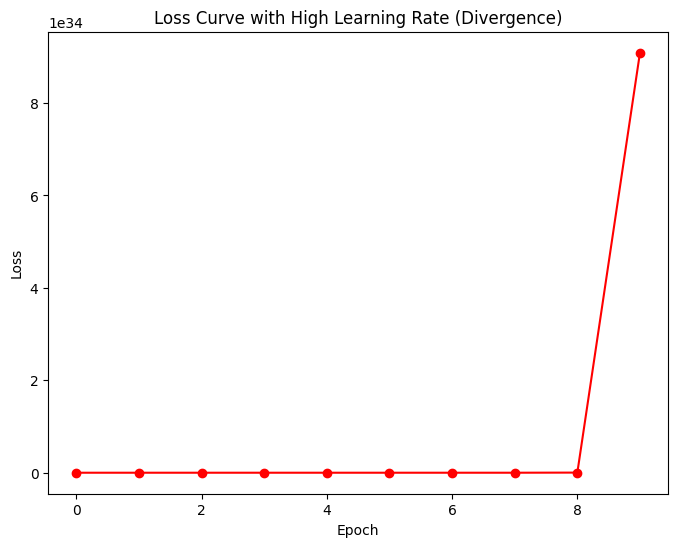

In [7]:
plt.figure(figsize=(8,6))
plt.plot(losses_div, 'r-o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve with High Learning Rate (Divergence)")

########################################
# Explanation of the Plot:
#  - You may see the first few points near zero (or relatively small) 
#    because the scale is overshadowed by the massive jump later.
#  - Then, around some epoch, the loss spikes drastically (e.g., >1e+30).
#  - This behavior confirms that the training has diverged.
########################################

plt.show()

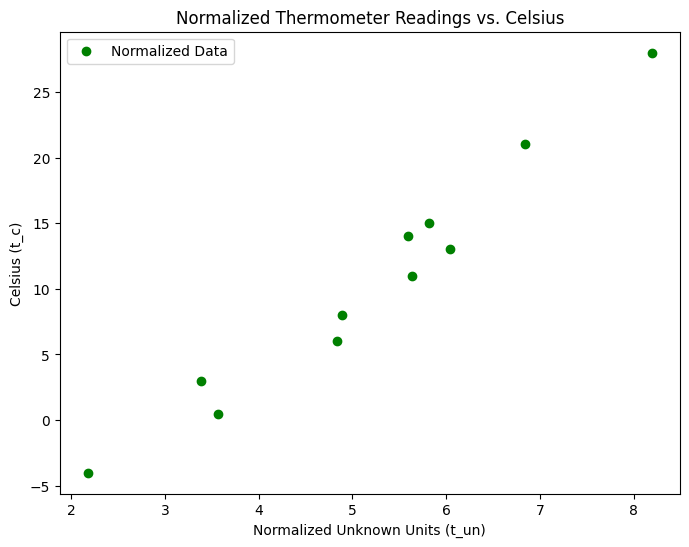

Training with normalized t_u (t_un) and learning rate 1e-2:
Epoch    1, Loss 80.364342, Params: tensor([1.7761, 0.1064]), Grad: tensor([-77.6140, -10.6400])
Epoch  500, Loss 7.860115, Params: tensor([ 4.0443, -9.8133]), Grad: tensor([-0.2252,  1.2748])
Epoch 1000, Loss 3.828538, Params: tensor([  4.8021, -14.1031]), Grad: tensor([-0.0962,  0.5448])
Epoch 1500, Loss 3.092191, Params: tensor([  5.1260, -15.9365]), Grad: tensor([-0.0411,  0.2328])
Epoch 2000, Loss 2.957698, Params: tensor([  5.2644, -16.7200]), Grad: tensor([-0.0176,  0.0995])
Epoch 2500, Loss 2.933134, Params: tensor([  5.3236, -17.0549]), Grad: tensor([-0.0075,  0.0425])
Epoch 3000, Loss 2.928648, Params: tensor([  5.3489, -17.1980]), Grad: tensor([-0.0032,  0.0182])
Epoch 3500, Loss 2.927830, Params: tensor([  5.3597, -17.2591]), Grad: tensor([-0.0014,  0.0078])
Epoch 4000, Loss 2.927680, Params: tensor([  5.3643, -17.2853]), Grad: tensor([-0.0006,  0.0033])
Epoch 4500, Loss 2.927651, Params: tensor([  5.3662, -17.2964

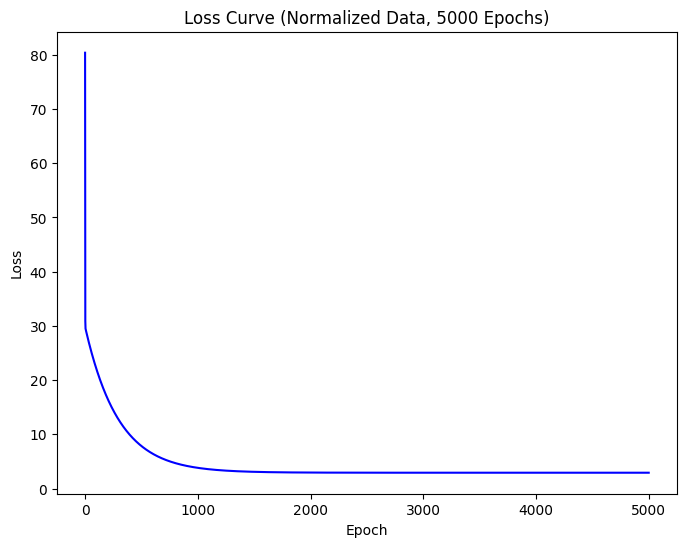

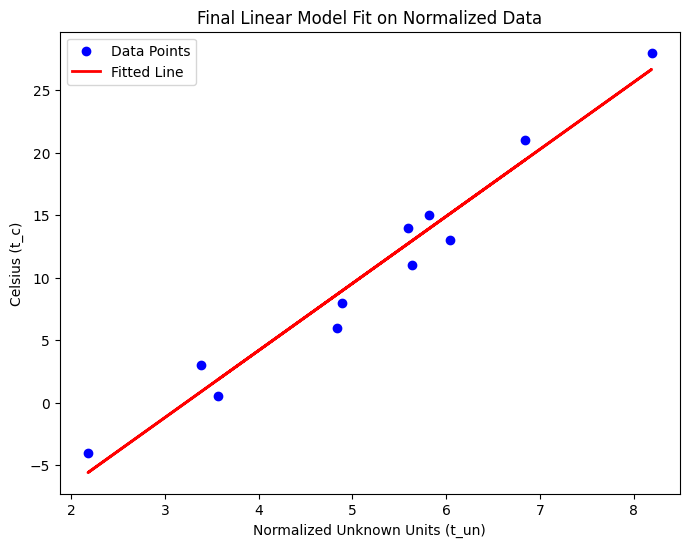

Final parameters (w, b): tensor([  5.3671, -17.3012])


In [9]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_every=500):
    losses = []
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        params = params - learning_rate * grad
        losses.append(loss.item())
        if epoch == 1 or epoch % print_every == 0:
            print(f"Epoch {epoch:4d}, Loss {loss.item():.6f}, Params: {params}, Grad: {grad}")
    return params, losses
#%% Normalize Input: Scale t_u to t_un
# Large gradients may arise because the input values are too high.
t_un = 0.1 * t_u  # Normalizing t_u by a factor of 0.1

plt.figure(figsize=(8,6))
plt.scatter(t_un.numpy(), t_c.numpy(), color='green', label='Normalized Data')
plt.xlabel('Normalized Unknown Units (t_un)')
plt.ylabel('Celsius (t_c)')
plt.title('Normalized Thermometer Readings vs. Celsius')
plt.legend()
plt.show()

#%% Train with Normalized Input and Moderate Learning Rate
print("Training with normalized t_u (t_un) and learning rate 1e-2:")
params_init = torch.tensor([1.0, 0.0])
params_conv, losses_conv = training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params=params_init,
    t_u=t_un,
    t_c=t_c,
    print_every=500
)

plt.figure(figsize=(8,6))
plt.plot(losses_conv, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve (Normalized Data, 5000 Epochs)')
plt.show()

#%% Plot Final Model Fit
t_p_final = model(t_un, params_conv[0], params_conv[1])
plt.figure(figsize=(8,6))
plt.scatter(t_un.numpy(), t_c.numpy(), color='blue', label='Data Points')
plt.plot(t_un.numpy(), t_p_final.detach().numpy(), color='red', linewidth=2, label='Fitted Line')
plt.xlabel('Normalized Unknown Units (t_un)')
plt.ylabel('Celsius (t_c)')
plt.title('Final Linear Model Fit on Normalized Data')
plt.legend()
plt.show()

#%% Display Final Parameters
print("Final parameters (w, b):", params_conv)
# With proper normalization, the final parameters should be stable.